Metode OTSU: 7 karakter potensial, skor: 7
Metode Adaptive: 7 karakter potensial, skor: 7
Metode Manual: 7 karakter potensial, skor: 7


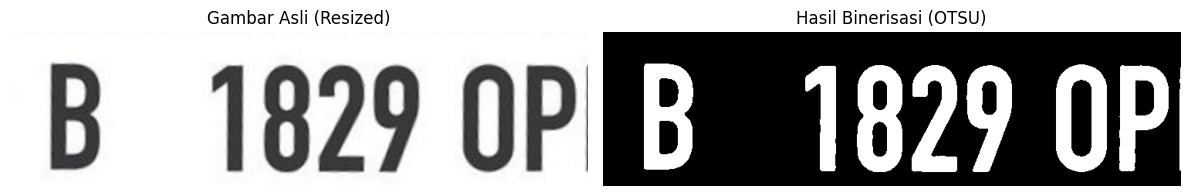


Metode preprocessing: OTSU
Dimensi plat: 749x200
Total kontur terdeteksi: 8
Parameter set 'Standard': 7 kandidat
Parameter set 'Wide_chars': 7 kandidat
Parameter set 'Narrow_chars': 7 kandidat
Kandidat terbaik: 7 karakter


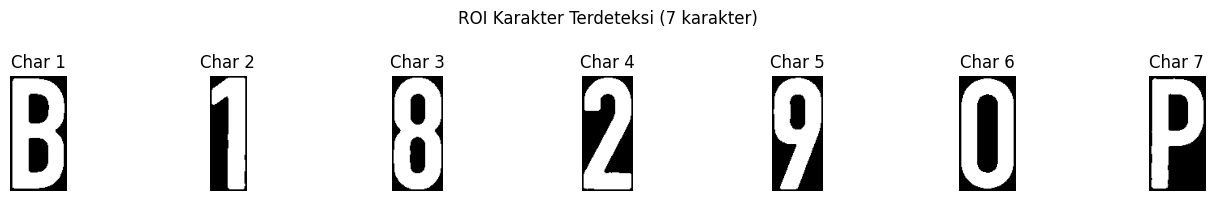

Karakter 1: 'B' (confidence: 0.961)
Karakter 2: '1' (confidence: 0.989)
Karakter 3: '8' (confidence: 0.958)
Karakter 4: '2' (confidence: 0.948)
Karakter 5: '9' (confidence: 0.827)
Karakter 6: '0' (confidence: 0.984)
Karakter 7: 'P' (confidence: 1.000)

Hasil Prediksi: 'B18290P'
Confidence rata-rata: 0.952

=== HASIL AKHIR ===
Plat Nomor: B18290P
Confidence: 0.952


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load model dan definisi label
model = load_model('/content/model_karakter_cnn.h5')
label_map = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'

def adaptive_preprocessing(image):
    """
    Preprocessing adaptif dengan multiple metode threshold
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # OTSU
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, binary_otsu = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Adaptive threshold
    binary_adaptive = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY_INV, 11, 2)

    # Manual threshold dengan nilai yang disesuaikan
    mean_val = np.mean(gray)
    thresh_val = max(mean_val - 30, 50)  # Threshold dinamis
    _, binary_manual = cv2.threshold(blurred, thresh_val, 255, cv2.THRESH_BINARY_INV)

    # Evaluasi kualitas masing-masing metode berdasarkan jumlah kontour yang masuk akal
    methods = [
        ("OTSU", binary_otsu),
        ("Adaptive", binary_adaptive),
        ("Manual", binary_manual)
    ]

    best_method = None
    best_score = 0

    for name, binary_img in methods:
        contours, _ = cv2.findContours(binary_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Hitung kontour yang berpotensi sebagai karakter
        potential_chars = 0
        h, w = binary_img.shape

        for contour in contours:
            x, y, cw, ch = cv2.boundingRect(contour)
            aspect_ratio = cw / float(ch) if ch > 0 else 0
            area = cv2.contourArea(contour)

            # Kriteria lebih longgar untuk evaluasi
            if (0.1 * h < ch < 0.8 * h and
                0.01 * w < cw < 0.25 * w and
                0.1 < aspect_ratio < 2.0 and
                area > 30):
                potential_chars += 1

        # Skor berdasarkan jumlah karakter potensial (optimal 6-10 untuk plat Indonesia)
        if 4 <= potential_chars <= 12:
            score = potential_chars
        else:
            score = max(0, 8 - abs(potential_chars - 8))  # Penalti jika terlalu jauh dari ideal

        print(f"Metode {name}: {potential_chars} karakter potensial, skor: {score}")

        if score > best_score:
            best_score = score
            best_method = (name, binary_img)

    return best_method[1], best_method[0]

def enhanced_character_segmentation(binary_image_plate, method_name=""):
    """
    Segmentasi karakter yang lebih fleksibel dengan multiple parameter sets
    """
    contours, _ = cv2.findContours(binary_image_plate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    plate_h, plate_w = binary_image_plate.shape[:2]
    print(f"\nMetode preprocessing: {method_name}")
    print(f"Dimensi plat: {plate_w}x{plate_h}")
    print(f"Total kontur terdeteksi: {len(contours)}")

    # Multiple parameter sets untuk berbagai jenis plat
    parameter_sets = [
        {
            "name": "Standard",
            "min_height_ratio": 0.15, "max_height_ratio": 0.75,
            "min_width_ratio": 0.015, "max_width_ratio": 0.20,
            "min_aspect": 0.1, "max_aspect": 1.5,
            "min_area_ratio": 0.002, "max_area_ratio": 0.10,
            "y_center_min": 0.25, "y_center_max": 0.75
        },
        {
            "name": "Wide_chars",
            "min_height_ratio": 0.20, "max_height_ratio": 0.80,
            "min_width_ratio": 0.020, "max_width_ratio": 0.25,
            "min_aspect": 0.2, "max_aspect": 2.0,
            "min_area_ratio": 0.003, "max_area_ratio": 0.12,
            "y_center_min": 0.20, "y_center_max": 0.80
        },
        {
            "name": "Narrow_chars",
            "min_height_ratio": 0.12, "max_height_ratio": 0.70,
            "min_width_ratio": 0.010, "max_width_ratio": 0.15,
            "min_aspect": 0.05, "max_aspect": 1.2,
            "min_area_ratio": 0.001, "max_area_ratio": 0.08,
            "y_center_min": 0.30, "y_center_max": 0.70
        }
    ]

    best_candidates = []
    best_count = 0

    for params in parameter_sets:
        candidates = []

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = w / float(h) if h > 0 else 0
            contour_area = cv2.contourArea(contour)

            # Kalkulasi parameter berdasarkan rasio
            min_height = params["min_height_ratio"] * plate_h
            max_height = params["max_height_ratio"] * plate_h
            min_width = params["min_width_ratio"] * plate_w
            max_width = params["max_width_ratio"] * plate_w
            min_area = int(params["min_area_ratio"] * plate_h * plate_w)
            max_area = int(params["max_area_ratio"] * plate_h * plate_w)

            y_center_relative = (y + h/2) / plate_h
            is_vertically_centered = (params["y_center_min"] < y_center_relative <
                                    params["y_center_max"])

            not_touching_edge = (y > 0.03 * plate_h) and ((y+h) < 0.97 * plate_h)

            if (min_height < h < max_height and
                min_width < w < max_width and
                params["min_aspect"] < aspect_ratio < params["max_aspect"] and
                min_area < contour_area < max_area and
                is_vertically_centered and
                not_touching_edge):

                # Ekstrak ROI dengan padding
                pad = max(2, int(0.05 * min(h, w)))
                roi = binary_image_plate[max(0, y - pad):min(plate_h, y + h + pad),
                                       max(0, x - pad):min(plate_w, x + w + pad)]

                if roi.size > 0:
                    candidates.append({'roi': roi, 'x': x, 'y': y, 'w': w, 'h': h})

        print(f"Parameter set '{params['name']}': {len(candidates)} kandidat")

        # Pilih parameter set dengan jumlah kandidat yang paling masuk akal
        if 4 <= len(candidates) <= 12:  # Range ideal untuk plat nomor Indonesia
            if len(candidates) > best_count:
                best_count = len(candidates)
                best_candidates = candidates
        elif len(candidates) > best_count and best_count < 4:
            # Jika belum ada yang ideal, ambil yang terbanyak
            best_count = len(candidates)
            best_candidates = candidates

    # Urutkan berdasarkan posisi x
    best_candidates.sort(key=lambda c: c['x'])

    # Ekstrak ROI
    sorted_rois = [candidate['roi'] for candidate in best_candidates]

    print(f"Kandidat terbaik: {len(sorted_rois)} karakter")

    return sorted_rois

def preprocess_roi_for_model(roi):
    """
    Preprocessing ROI yang lebih robust
    """
    # Pastikan ROI tidak kosong
    if roi.size == 0:
        return None

    # Resize dengan mempertahankan aspect ratio jika perlu
    roi_resized = cv2.resize(roi, (22, 22), interpolation=cv2.INTER_AREA)

    # Tambah border
    roi_padded = cv2.copyMakeBorder(roi_resized, 3, 3, 3, 3, cv2.BORDER_CONSTANT, value=[0,0,0])

    # Normalisasi
    roi_normalized = roi_padded.astype('float32') / 255.0

    # Convert ke format yang dibutuhkan model
    roi_array = img_to_array(roi_normalized)
    if roi_array.shape[-1] != 1:
        roi_array = roi_array[:,:,0]
        roi_array = np.expand_dims(roi_array, axis=-1)

    roi_batch = np.expand_dims(roi_array, axis=0)

    return roi_batch

def predict_license_plate(image_path):
    """
    Fungsi utama untuk prediksi plat nomor
    """
    # Baca dan preprocess gambar
    image_orig = cv2.imread(image_path)
    if image_orig is None:
        raise FileNotFoundError(f"Gambar tidak ditemukan di path: {image_path}")

    # Resize gambar plat
    image_height_orig, image_width_orig, _ = image_orig.shape
    target_height_plate = 200
    scale_plate = target_height_plate / image_height_orig
    target_width_plate = int(image_width_orig * scale_plate)
    image_resized_plate = cv2.resize(image_orig, (target_width_plate, target_height_plate))

    # Preprocessing adaptif
    binary_plate, method_used = adaptive_preprocessing(image_resized_plate)

    # Tampilkan hasil preprocessing
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image_resized_plate, cv2.COLOR_BGR2RGB))
    plt.title("Gambar Asli (Resized)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(binary_plate, cmap='gray')
    plt.title(f"Hasil Binerisasi ({method_used})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Segmentasi karakter
    sorted_character_rois = enhanced_character_segmentation(binary_plate, method_used)

    if not sorted_character_rois:
        print("\nTidak ada karakter yang terdeteksi.")
        return ""

    # Tampilkan ROI yang terdeteksi
    num_chars = len(sorted_character_rois)
    if num_chars > 0:
        cols = min(8, num_chars)
        rows = (num_chars + cols - 1) // cols

        plt.figure(figsize=(2*cols, 2*rows))
        for i, roi in enumerate(sorted_character_rois):
            plt.subplot(rows, cols, i + 1)
            plt.imshow(roi, cmap='gray')
            plt.title(f"Char {i+1}")
            plt.axis('off')
        plt.suptitle(f"ROI Karakter Terdeteksi ({num_chars} karakter)")
        plt.tight_layout()
        plt.show()

    # Prediksi karakter
    predicted_text = ''
    confidences = []

    for i, roi_img in enumerate(sorted_character_rois):
        preprocessed_char = preprocess_roi_for_model(roi_img)

        if preprocessed_char is not None:
            prediction = model.predict(preprocessed_char, verbose=0)
            predicted_char_index = np.argmax(prediction)
            confidence = np.max(prediction)

            if 0 <= predicted_char_index < len(label_map):
                char_label = label_map[predicted_char_index]
                predicted_text += char_label
                confidences.append(confidence)
                print(f"Karakter {i+1}: '{char_label}' (confidence: {confidence:.3f})")
            else:
                predicted_text += "?"
                confidences.append(0.0)
        else:
            predicted_text += "?"
            confidences.append(0.0)

    avg_confidence = np.mean(confidences) if confidences else 0.0
    print(f"\nHasil Prediksi: '{predicted_text}'")
    print(f"Confidence rata-rata: {avg_confidence:.3f}")

    return predicted_text, avg_confidence

# Contoh penggunaan
image_path = '/content/B1829OP.png'
try:
    result, confidence = predict_license_plate(image_path)
    print(f"\n=== HASIL AKHIR ===")
    print(f"Plat Nomor: {result}")
    print(f"Confidence: {confidence:.3f}")
except Exception as e:
    print(f"Error: {e}")

# Fungsi untuk batch processing multiple images
def batch_predict_plates(image_paths):
    """
    Prediksi batch untuk multiple gambar
    """
    results = []
    for i, path in enumerate(image_paths):
        print(f"\n{'='*50}")
        print(f"Processing image {i+1}/{len(image_paths)}: {path}")
        print(f"{'='*50}")

        try:
            result, confidence = predict_license_plate(path)
            results.append({
                'path': path,
                'prediction': result,
                'confidence': confidence,
                'status': 'success'
            })
        except Exception as e:
            print(f"Error processing {path}: {e}")
            results.append({
                'path': path,
                'prediction': '',
                'confidence': 0.0,
                'status': 'error',
                'error': str(e)
            })

    return results